# Video Magnification

## Implement Eulerian Video Magnication

Eulerian
video magnification is done as a sequence of the following steps:
1. If your video has color, transform it to an appropriate color space.
2. Create a Laplacian pyramid for each video frame.
3. Band-pass filter the time series for each pixel, on all levels of the pyramid.
4. Magnify bands of interest by some scale.
5. Reverse the Laplacian pyramid and undo the color transform to obtain the final output.

### 1.Initials and color transformation

Load the video file , extract its frames, and convert them to double-precision in the range [0; 1]

Then, convert each of the frames to the YIQ color space. The YIQ color space is particularly suggested
for Eulerian magnification because it allows to easily amplify intensity and chromaticity independently of
each other. All subsequent steps in this problem will be performed on each color channel independently.
(See help for rgb2ntsc and ntsc2rgb about converting between RGB and YIQ.)

In [32]:
import os

import cv2
import numpy as np
import colorsys


import matplotlib.pyplot as plt

def bgr_to_yiq(b, g, r):
    y = np.float64(0.299*r + 0.587*g + 0.114*b)
    i = np.float64(0.596*r - 0.274*g - 0.322*b)
    q = np.float64(0.212*r - 0.523*g + 0.311*b)
    return y,i,q

def yiq_to_bgr(y,i,q):
    r = y + 0.956*i + 0.621*q
    g = y - 0.272*i - 0.647*q
    b = y - 1.105*i + 1.702*q
    return b,g,r

def double_to_uint8(c1):
    c1[c1<0] = 0
    c1[c1>255] = 255
    
    c1 = np.uint8(c1)
    return c1

'''
Load video and convert rgb frame to YIQ
Y: Luminance, Brightness
I: In-phase,色彩从橙色到青色
Q: Quadrature-phase,色彩从紫色到黄绿色
'''
def load_video(video_filename):

    if not os.path.isfile(video_filename):
        raise Exception("File Not Found: %s" % video_filename)
    
    ## read video
    capture = cv2.VideoCapture(video_filename)
    frame_count = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))
    width, height = int(capture.get(cv2.CAP_PROP_FRAME_WIDTH)),int(capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(capture.get(cv2.CAP_PROP_FPS))
    print("video width:%d, height:%d, frame_count:%d, fps:%d" %(width, height, frame_count, fps))
    vid_frames = np.zeros((frame_count+2, height, width, 3), dtype='float64')

    x = 0
    while capture.isOpened():
        ret, frame = capture.read()
        if ret is True:
#                 y,i,q = colorsys.rgb_to_yiq(frame[:,:,2]/1.0, frame[:,:,1]/1.0, frame[:,:,0]/1.0)

            yiq_frame = np.zeros((height, width, 3), dtype='float64')
            y1,i1,q1 = bgr_to_yiq(frame[:,:,0], frame[:,:,1], frame[:,:,2])
            yiq_frame[:,:,0] = y1
            yiq_frame[:,:,1] = i1
            yiq_frame[:,:,2] = q1
            vid_frames[x] = yiq_frame
            x += 1

        else:
            break

    capture.release()
    return vid_frames, fps

def load_video2(video_filename):

    if not os.path.isfile(video_filename):
        raise Exception("File Not Found: %s" % video_filename)
    
    ## read video
    capture = cv2.VideoCapture(video_filename)
    frame_count = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))
    width, height = int(capture.get(cv2.CAP_PROP_FRAME_WIDTH)),int(capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(capture.get(cv2.CAP_PROP_FPS))
    print("video width:%d, height:%d, frame_count:%d, fps:%d" %(width, height, frame_count, fps))
    frame_count = 100
    vid_frames = np.zeros((frame_count, height, width, 3), dtype='float64')

    x = 0
    while capture.isOpened():
        ret, frame = capture.read()
        if ret is True:
            if(x < 100):
                yiq_frame = np.zeros((height, width, 3), dtype='float64')
#                 y,i,q = colorsys.rgb_to_yiq(frame[:,:,2]/1.0, frame[:,:,1]/1.0, frame[:,:,0]/1.0)
                y1,i1,q1 = bgr_to_yiq(frame[:,:,0], frame[:,:,1], frame[:,:,2])
                yiq_frame[:,:,0] = y1
                yiq_frame[:,:,1] = i1
                yiq_frame[:,:,2] = q1

                vid_frames[x] = yiq_frame
            x += 1

        else:
            break

    capture.release()
    return vid_frames, fps
'''
show figures
imageLists:   all the show image in lists
imageTitles:  all the image titles in lists, it's responce to imageLists
colNum:       the number of cols
supTitle:     add a centered title to the figure
isGray:       the image is draw in gray channel
'''
def show_figures(imageLists, imageTitles, col, supTitle='', isGray=False):
    plt.figure(figsize=(20,10))
    if supTitle.strip() != '':
        plt.suptitle(supTitle, fontsize=15)

    imageSize = len(imageLists)
    p1 = imageSize / col

    i = 1
    for image in imageLists:
        plt.subplot(p1,col,i)
        if(isGray):
            plt.imshow(image, cmap=plt.cm.gray)
        else:
            plt.imshow(image)
        
        plt.title(imageTitles[i-1])
        i = i + 1

    plt.show()

### 1.1 show the YIQ image

video width:640, height:352, frame_count:898, fps:29


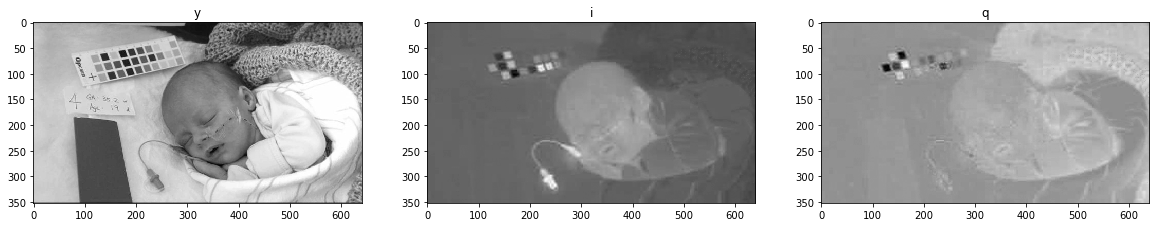

In [33]:
video_filename = '../data/baby2.mp4'
vframes, fps = load_video2(video_filename)

imageLists = [vframes[0][:,:,0], vframes[0][:,:,1], vframes[0][:,:,2]]
imageTitles = ["y", "i", "q"]
show_figures(imageLists, imageTitles, 3, isGray=True)

### 2. Laplacian pyramid construction 

The next step towards motion magnification is to construct a Laplacian pyramid for every frame in the video sequence. This can be done in many, approximately equivalent ways. 

One was discussed in class: Iterate steps of Gaussian blurring, differencing, and downsampling, then store the image differences and the lowest resolution image. 

An alternative is to directly use Laplacian-of-Gaussian filtering. 

### 2.1 laplacian pyramid

In [35]:
'''
Build gaussian pyramid
src:    source image
level:  the level of  pyramid

repeat:
    gaussian filter
    subsample
until min resolution reached
'''
def build_gaussian_pyramid(src,level=4):
    s=src.copy()
    pyramid=[s]
    for i in range(level-1):
        s = cv2.GaussianBlur(s, (3,3),1)
        s=cv2.pyrDown(s)
        pyramid.append(s)
    return pyramid

'''
Build laplacian pyramid
src:    source image
level:  the level of  pyramid

repeat:
    upsample
    sum with residual
until orig resolution reached
'''
def build_laplacian_pyramid(src,levels=4):
    gaussianPyramid = build_gaussian_pyramid(src, levels)
    pyramid=[]
    for i in range(levels-1):
        upGaussian=cv2.pyrUp(gaussianPyramid[i+1])
        L=cv2.subtract(gaussianPyramid[i],upGaussian)
        pyramid.append(L)
    pyramid.append(gaussianPyramid[-1])
    return pyramid

'''
Iterate video frame of laplacian, store levels * frame_count images
vframe:    video frames
level:     the level of  pyramid

repeat:
    create frame_count * lapPyramid[levels].shape * 3channels lists
until reached levesl
'''
def iterate_video(vframe,levels=4):
    tensor_list=[]
    for i in range(0,vframe.shape[0]):
        frame=vframe[i]
        pyr=build_laplacian_pyramid(frame,levels=levels)
        if i==0:
            for k in range(levels):
                tensor_list.append(np.zeros((vframe.shape[0],pyr[k].shape[0],pyr[k].shape[1],3)))
        for n in range(levels):
            tensor_list[n][i] = pyr[n]
    return tensor_list

### 2.2 Show laplacian image

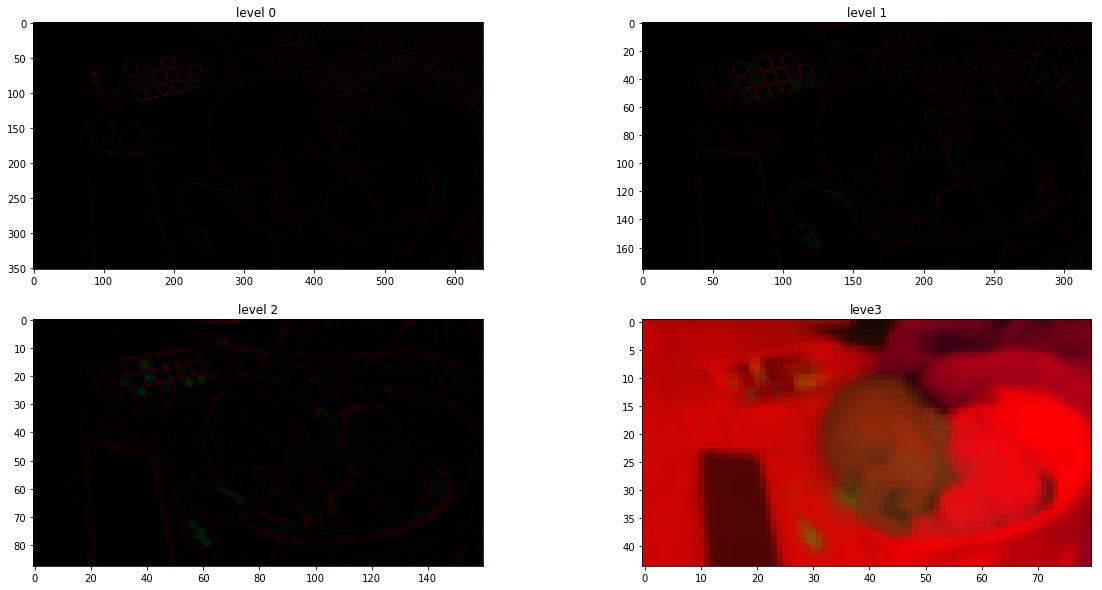

In [36]:
# p = build_gaussian_pyramid(vframes[0], 4)
# imageLists = [p[0], p[1],p[2], p[3]]
# imageTitles = ["level 0 ", "level 1", "level 2", "level 3"]
# supTitle = 'Show Laplacian Pyramid'
# show_figures(imageLists, imageTitles, 2, supTitle, isGray=False)

l = build_laplacian_pyramid(vframes[0], 4)

r1 = double_to_uint8(l[0])
r2 = double_to_uint8(l[1])
r3 = double_to_uint8(l[2])
r4 = double_to_uint8(l[3])
imageLists = [r1, r2, r3, r4]
imageTitles = ["level 0 ", "level 1", "level 2", "leve3"]
show_figures(imageLists, imageTitles, 2, isGray=False)

### 3. Temporal filtering
At each spatial level of the Laplacian pyramid, look at the values of each pixel across all video frames. This time series of values is a temporal signal that you can filter like any other signal, as we discussed in class. You will need to apply a band-pass filter to this time series. The choice of the band-pass filter is crucial.

In order to filter the time series of all pixels fast, you should perform this operation in
the frequency domain, since multiplication is faster than convolution. 

### 3.1 Learn to use Band-pass butter filter

According to magnify pulse, we can look at pixel variations with frequencies between 0.4 and 4Hz

### 3.2 Temporam filtering 

In [125]:
from scipy import signal
import math

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='bandpass')
    y = signal.lfilter(b, a, data, axis=0)
    return y

def temporal_bandpass_filter(data, freq_min=0.3, freq_max=1, fps=30, axis=0):
    fft = scipy.fftpack.rfft(data, axis=axis)
    frequencies = scipy.fftpack.fftfreq(data.shape[0], d=1.0 / fps)
    bound_low = (np.abs(frequencies - freq_min)).argmin()
    bound_high = (np.abs(frequencies - freq_max)).argmin()
    fft[:bound_low] = 0
    fft[bound_high:-bound_high] = 0
    fft[-bound_low:] = 0

    result = np.ndarray(shape=data.shape, dtype='float')
    result[:] = scipy.fftpack.ifft(fft, axis=0)
    return result



### 3.3 Pixel change magnification

Amplify extracting the frequency band of interest and add the result back to the original signal

In [120]:
def amplify_signal(frames, amplification):
    return frames * amplification

### 4.Image reconstruction

After amplifying the signals, it is now time to collapse the Laplacian pyramids into a single image per frame. As discussed in class,
this will require (among other steps) upsampling images from one level of the pyramid to the next lower one. 

In [121]:
def reconstract_from_tensorlist(filter_tensor_list,levels=4):
    final=np.zeros(filter_tensor_list[0].shape)
    for i in range(filter_tensor_list[-1].shape[0]):
        up = filter_tensor_list[-1][i]
        for n in range(levels - 2, -1, -1):
            up=cv2.pyrUp(up)+filter_tensor_list[n][i]

        final[i]=up
    return final



### 4.1 Convert YIQ back to BGR and Save Video

In [122]:
'''
convert video frame from YIQ to BGR
'''
def video_to_bgr(input_frames):
    out = np.zeros(input_frames.shape)
    
#     for i in range(input_frames[0].shape[0]):
    for i in range(100):
        y1 = input_frames[i][:,:,0]
        i1 = input_frames[i][:,:,1]
        q1 = input_frames[i][:,:,2]

        bgr_image = np.zeros(input_frames[0].shape, dtype='uint8')

        b,g,r = yiq_to_bgr(y1, i1, q1)
        bgr_image[:,:,2] = double_to_uint8(r)
        bgr_image[:,:,1] = double_to_uint8(g)
        bgr_image[:,:,0] = double_to_uint8(b)
        out[i] = bgr_image

    return out

'''
video_name:   save video path
video_tensor: video data
fps:          video fps
'''
def save_video(video_path, video_tensor, fps):
    fourcc = cv2.VideoWriter_fourcc('M','J','P','G')
    [height,width] = video_tensor[0].shape[0:2]

    writer = cv2.VideoWriter(video_path, fourcc, fps, (width, height), 1)
    for i in range(0,video_tensor.shape[0]):
        writer.write(cv2.convertScaleAbs(video_tensor[i]))
    writer.release()


### 5. Test the butter pass and amplification parameters

In [123]:
def magnify_motion(video_name, save_video_name, lower, higher, levels=4, amplification=20):
    vframes, fps = load_video2(video_name)
    lap_video_list = iterate_video(vframes,levels=levels)
    filter_tensor_list=[]
    for i in range(levels):
        filter_tensor = butter_bandpass_filter(lap_video_list[i],low,high,fps)
        filter_tensor = amplify_signal(filter_tensor, amplification)
        
        filter_tensor_list.append(filter_tensor)

    recon = reconstract_from_tensorlist(filter_tensor_list)
    final = vframes+recon
    video_bgr = video_to_bgr(final)
    save_video(save_video_name, video_bgr, fps)
    

def magnify_motion2(video_name, save_video_name, lower, higher, levels=4, amplification=20):
    vframes, fps = load_video2(video_name)
    lap_video_list = iterate_video(vframes,levels=levels)
    print(lap_video_list[0].shape)
    filter_tensor_list=[]
    for i in range(levels):
        filter_tensor = temporal_bandpass_filter(lap_video_list[i], lower, higher, fps)
        filter_tensor = amplify_signal(filter_tensor, amplification)
        filter_tensor_list.append(filter_tensor)

    print(filter_tensor_list[0].shape)

    recon = reconstract_from_tensorlist(filter_tensor_list)
    final = vframes+recon
    video_bgr = video_to_bgr(final)
    save_video(save_video_name, video_bgr, fps)

### 5.1 Use different parameters to do butter pass

In [130]:
VIDEO_PARAMETERS = [
    # name, amplification_factor, cutoff, lower_freq, higher_freq, levels
#     ('baby2', 10, 0.4, 3, 4),
#     ('baby2', 10, 0.83, 1.0, 4),
#     ('baby2', 10, 0.8, 4.0, 4),
#     ('baby2', 10, 1.0, 3.0, 4),
#     ('baby2', 10, 1.0, 2.0, 4),
    ('baby2', 5, 1.0, 2.0, 4),
]

def replicate_test():
    for name, amplification_factor, lower_freq, higher_freq, levels in VIDEO_PARAMETERS:
        ## get input name
        input_filename = "../data/" + name + ".mp4"
        ## according to parameters to get output name
        output_filename = "../data/" + name + "_lower" + str(lower_freq) + "_higer" + str(higher_freq) + "_amp" + str(amplification_factor) + "_levels" + str(levels)+".mp4"
        print("input file:" + input_filename)
        print("output file:" + output_filename)

        vid = magnify_motion2(input_filename, output_filename,
                             lower=lower_freq, higher=higher_freq, 
                             levels=levels, 
                             amplification=amplification_factor)



if __name__ == '__main__':
    replicate_test()

input file:../data/baby2.mp4
output file:../data/baby2_lower1.0_higer2.0_amp5_levels4.mp4
video width:640, height:352, frame_count:898, fps:29
(100, 352, 640, 3)


/Users/cc_xueqin/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:22: ComplexWarning: Casting complex values to real discards the imaginary part


(100, 352, 640, 3)


In [30]:
len(filter_tensor_list)











4

/Users/cc_xueqin/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:72: ComplexWarning: Casting complex values to real discards the imaginary part


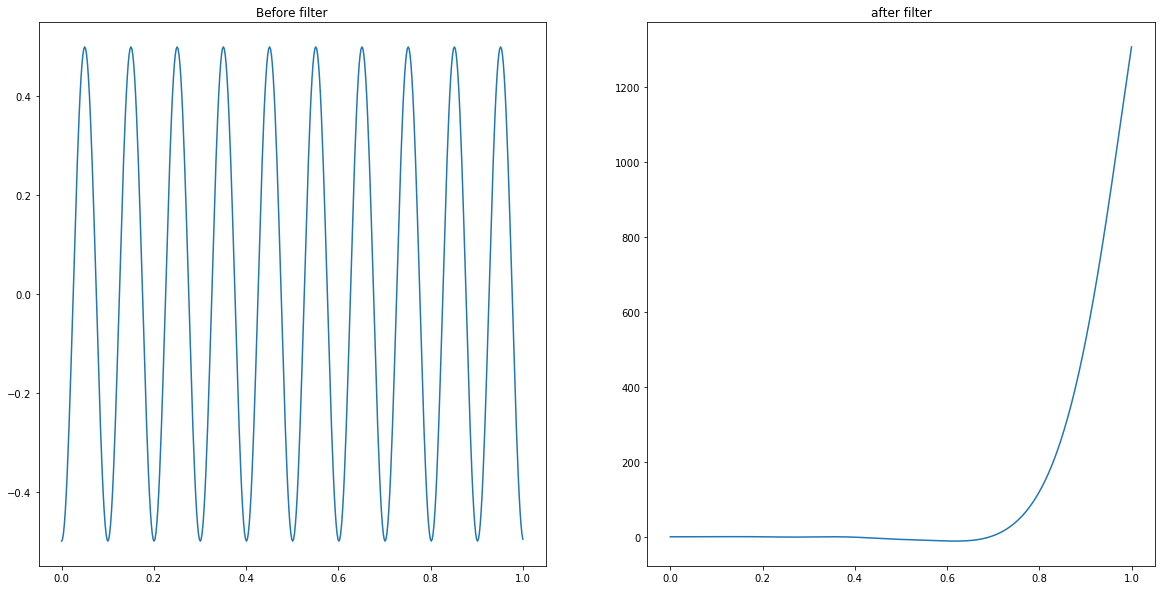

In [103]:
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
import matplotlib



# def test_butter_bandpass():
N = 500
fs = 5
n = [2*math.pi*fs*t/N for t in range(N)]
axis_x = np.linspace(0,1,num=N)

# plt.figure(figsize=(20,10)) 
#频率为5Hz的正弦信号
x = [math.sin(i) for i in n]
# plt.subplot(221)
# plt.plot(axis_x,x)
# plt.title('5Hz sin signal')

# 5Hz与50Hz的正弦叠加信号
xx = []
x1 = [math.sin(i*10) for i in n]
for i in range(len(x)):
    xx.append(x[i] + x1[i])

# plt.subplot(222)
# plt.plot(axis_x,xx)
# plt.title('5Hz-50Hz sin signal added result')


# ## 低通滤波后
# b,a = signal.butter(3,0.08,'low')
# sf = signal.filtfilt(b,a,xx)
# # sf = butter_bandpass_filter(xx, 0.08, 3, N, 4)


# plt.subplot(223)
# plt.plot(axis_x,sf)
# plt.title('after low butter filter')
 
# ## 高通滤波后
# b,a = signal.butter(3,0.10,'high')
# sf = signal.filtfilt(b,a,xx)
# # sf = butter_bandpass_filter(xx, 0.10, 3, N, 4)

# plt.subplot(224)
# plt.plot(axis_x,sf)
# plt.title('after high buter filter')
# plt.show()


def butter_bandpass_filter1(data, lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='bandpass')
    y = signal.lfilter(b, a, data, axis=0)
    return y

def temporal_bandpass_filter1(data, freq_min=0.3, freq_max=1, fps=30, axis=0, amplification_factor=1):
#     print("Applying bandpass between " + str(freq_min) + " and " + str(freq_max) + " Hz")
    fft = scipy.fftpack.rfft(data, axis=axis)
    frequencies = scipy.fftpack.fftfreq(1000, d=1.0 / fps)
    bound_low = (np.abs(frequencies - freq_min)).argmin()
    bound_high = (np.abs(frequencies - freq_max)).argmin()
    fft[:bound_low] = 0
    fft[bound_high:-bound_high] = 0
    fft[-bound_low:] = 0

    result = np.ndarray(shape=len(data), dtype='float')
    result[:] = scipy.fftpack.ifft(fft, axis=0)
    result *= amplification_factor
    return result

plt.figure(figsize=(20,10)) 

band_r = temporal_bandpass_filter1(xx, 0.8, 1.5, 100)
plt.subplot(121)
plt.plot(axis_x, band_r)
plt.title('Before filter')

filterY = butter_bandpass_filter1(xx, 0.1, 1.0, 100)
pl.subplot(122)
plt.plot(axis_x, filterY)
plt.title('after filter')
plt.show()


/Users/cc_xueqin/anaconda/lib/python2.7/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


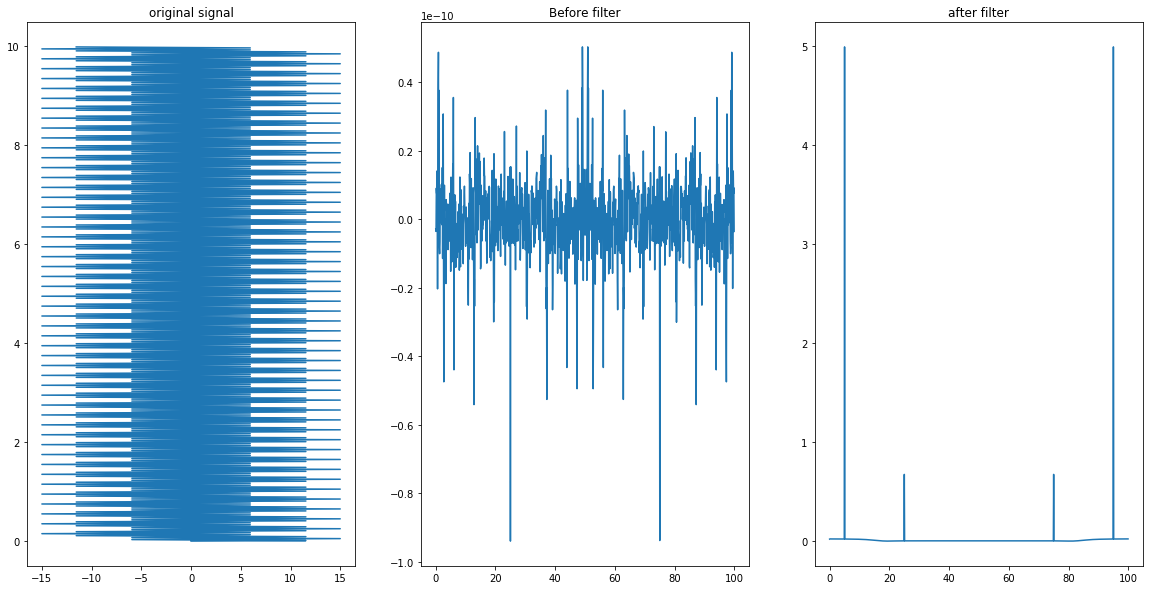

In [73]:
import scipy.signal as signal
import matplotlib.pyplot as pl
import numpy as np
import math
 
from scipy.signal import butter, lfilter

    
sampRat = 100
dt = 1/sampRat
T = 10
 
t = np.linspace(0, T, T*sampRat, endpoint=False)
y = 5*np.sin(2*math.pi*t*5)+10*np.sin(2*math.pi*t*25)

plt.figure(figsize=(20,10)) 
pl.subplot(131)
pl.plot(y,t)
plt.title('original signal')


filterY = butter_bandpass_filter(y, 0.01, 15, sampRat, 4)
f = np.linspace(0, sampRat, T*sampRat, endpoint=False)
ff = np.fft.fft(y)
# ff = np.abs(ff)*2/T/sampRat
 
pl.subplot(132)
plt.plot(f, ff)
plt.title('Before filter')
 
ff = np.fft.fft(filterY)
ff = np.abs(ff)*2/T/sampRat
 
pl.subplot(133)
plt.plot(f, ff)
plt.title('after filter')
plt.show()
